In [1]:
import sys
sys.path.append("/home2/sdokania/all_projects/project-noisypixel/")

In [2]:
import os
import glob
import cv2
import random
import pandas as pd
from skimage import io
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import h5py

# Network building stuff
import torch
import torch.nn as nn
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import torchmetrics
import torch.distributions as dist


#mesh
from src.utils.libmise.mise import  MISE
from src.utils.libmcubes.mcubes import marching_cubes
import trimesh

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from src.models import *
from src.dataset.dataloader import OccupancyNetDatasetHDF
from src.trainer import ONetLit
from src.utils import Config, count_parameters

In [189]:
config = Config()
config.data_root = "/ssd_scratch/cvit/sdokania/processed_data/hdf_data/"
config.batch_size = 32
config.output_dir = '../occ_artifacts/'
config.exp_name = 'mesh_exp'
# config.encoder = "resnet-18"
# config.decoder = "decoder-cbn"
# config.c_dim = 256

config.encoder = "efficientnet-b0"
config.decoder = "decoder-cbn"
# config.c_dim = 256

Setting sexperiment path as : /home2/sdokania/all_projects/occ_artifacts/initial
Setting sexperiment path as : ../occ_artifacts/mesh_exp


In [190]:
vars(config)

{'c_dim': 128,
 'h_dim': 128,
 'p_dim': 3,
 'data_root': '/ssd_scratch/cvit/sdokania/processed_data/hdf_data/',
 'batch_size': 32,
 'output_dir': '../occ_artifacts/',
 '_exp_name': 'mesh_exp',
 'encoder': 'efficientnet-b0',
 'decoder': 'decoder-cbn',
 'lr': 0.0003,
 'exp_path': '../occ_artifacts/mesh_exp'}

In [191]:
onet = ONetLit(config)

Loaded pretrained weights for efficientnet-b0


In [209]:
net = ONetLit.load_from_checkpoint("../occ_artifacts/efficient_cbn_bs_64_full_data/lightning_logs/version_1/checkpoints/epoch=131-step=63359.ckpt", cfg=config).eval()
# net = ONetLit.load_from_checkpoint("../occ_artifacts/resnet50_fc_bs_64_full_data_balanced/lightning_logs/version_1/checkpoints/epoch=157-step=75770.ckpt", cfg=config).eval()
# net = ONetLit.load_from_checkpoint("../occ_artifacts/efficient_fcdecoder_bs_64_full_data/lightning_logs/version_1/checkpoints/epoch=129-step=62399.ckpt", cfg=config)

# net = ONetLit.load_from_checkpoint("../occ_artifacts/resnet18_cbn_bs_256_sub_data_balanced/lightning_logs/version_1/checkpoints/epoch=85-step=2235.ckpt", cfg=config).eval()

Loaded pretrained weights for efficientnet-b0


In [234]:
dataset = OccupancyNetDatasetHDF(config.data_root, num_points=2048, mode="test")
print(len(dataset))

8751


In [235]:
# enc = torch.load()

In [283]:
dataset = OccupancyNetDatasetHDF(config.data_root, num_points=2048, mode="test", point_cloud=True)

/ssd_scratch/cvit/sdokania/processed_data/hdf_data/04256520_cc7b690e4d86b471397aad305ec14786.h5


In [236]:
def make_3d_grid(bb_min, bb_max, shape):
    ''' Makes a 3D grid.
    Args:
        bb_min (tuple): bounding box minimum
        bb_max (tuple): bounding box maximum
        shape (tuple): output shape
    '''
    size = shape[0] * shape[1] * shape[2]

    pxs = torch.linspace(bb_min[0], bb_max[0], shape[0])
    pys = torch.linspace(bb_min[1], bb_max[1], shape[1])
    pzs = torch.linspace(bb_min[2], bb_max[2], shape[2])

    pxs = pxs.view(-1, 1, 1).expand(*shape).contiguous().view(size)
    pys = pys.view(1, -1, 1).expand(*shape).contiguous().view(size)
    pzs = pzs.view(1, 1, -1).expand(*shape).contiguous().view(size)
    p = torch.stack([pxs, pys, pzs], dim=1)

    return p

In [237]:
def eval_points(p, c, points_batch_size=100000):
    """
    """
    p_split = torch.split(p, points_batch_size)
    # print(len(p_split))
    occ_hats = []

    for pi in p_split:
        pi = pi.unsqueeze(0) 
        with torch.no_grad():
            occ_hat = net.net.decoder(pi, c)

        occ_hats.append(occ_hat.squeeze(0).detach().cpu())

    occ_hat = torch.cat(occ_hats, dim=0)

    return occ_hat

In [287]:
def extract_mesh(occ_hat, padding=0.1, threshold_g=0.2, return_points=False):
    n_x, n_y, n_z = occ_hat.shape
    box_size = 1 + padding
    threshold = np.log( threshold_g) - np.log(1. - threshold_g)
    
    occ_hat_padded = np.pad(occ_hat, 1, 'constant', constant_values=-1e6)
    print(threshold,occ_hat_padded.shape, np.min(occ_hat_padded), np.max(occ_hat_padded))
    vertices, triangles = marching_cubes(occ_hat_padded, threshold)
  
    vertices -= 0.5
    # Undo padding
    vertices -= 1
    # Normalize to bounding box
    vertices /= np.array([n_x-1, n_y-1, n_z-1])
    vertices = box_size * (vertices - 0.5)
    
    normals = None

    mesh = build_mesh(vertices, triangles)
    return mesh

In [288]:
def build_mesh(vertices, triangles, normals=None):
    mesh = trimesh.Trimesh(vertices, triangles, vertex_normals=normals, process=False)
    return mesh

In [289]:
def get_mesh(data, padding=0.1, resolution0=32, upsampling_steps=2, threshold_g=0.2):
    # Get the image, points, and the ground truth
    test_img, test_pts, test_gt = data
    
    # Get the threshold and the box padding
    threshold = np.log( threshold_g) - np.log(1. - threshold_g)
    box_size = 1 +  padding
    nx = 32
    pointsf = 2 * make_3d_grid((-0.5,)*3, (0.5,)*3, (nx,)*3    )
    c = net.net.encoder(test_img.unsqueeze(0))#.detach()
    
    if(upsampling_steps==0): 
        values = eval_points(pointsf,c ).cpu().numpy()
        value_grid = values.reshape(nx, nx, nx)
    else:
        mesh_extractor = MISE(resolution0, upsampling_steps, threshold)
        points = mesh_extractor.query()
        while points.shape[0] != 0:
            # Query points
            pointsf = torch.FloatTensor(points) 
            # Normalize to bounding box
            pointsf = pointsf / mesh_extractor.resolution
            pointsf = box_size * (pointsf - 0.5)
            # Evaluate model and update
            # print(pointsf.shape, c.shape)
            values = eval_points( pointsf, c).cpu().numpy()
            values = values.astype(np.float64)
            mesh_extractor.update(points, values)
            points = mesh_extractor.query()
        value_grid = mesh_extractor.to_dense()     
    mesh = extract_mesh(value_grid, threshold_g=threshold_g)
    
    return mesh

In [240]:
# mesh = get_mesh(dataset)


# mesh_out_file = os.path.join('./', '%s.off' % 'onet')
# opf = mesh.export(mesh_out_file)

In [233]:
mesh_out_file = os.path.join('./', '%s.off' % 'onet')
opf = mesh.export(mesh_out_file)

/home2/sdokania/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

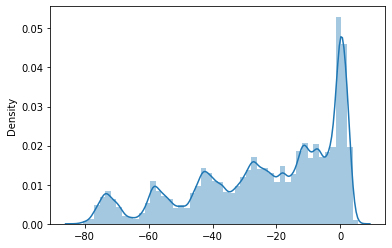

In [37]:
sns.distplot(value_grid.flatten())

<ipython-input-91-5c50bd0190d5>:2: RuntimeWarning: divide by zero encountered in log
  y = np.log(x) - np.log(1 - x)


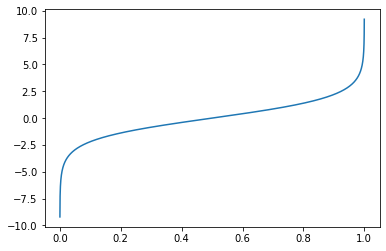

In [91]:
x = np.linspace(0, 1, 10000)
y = np.log(x) - np.log(1 - x)

plt.plot(x, y)

/home2/sdokania/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

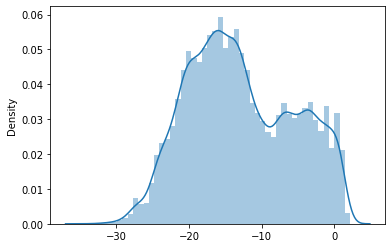

In [28]:
# old_values = values.copy()
sns.distplot(old_values)

In [64]:
import tqdm

In [57]:
# prepare a subset of the training dataset for overfitting the model
train_path = dataset = OccupancyNetDatasetHDF(config.data_root, num_points=2048).files

In [65]:
classes = {}
for ix in tqdm.tqdm_notebook(train_path):
    cid, fid = ix.split("_")
    classes.setdefault(cid, []).append(fid)

<ipython-input-65-959cb7d2603f>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ix in tqdm.tqdm_notebook(train_path):


  0%|          | 0/30661 [00:00<?, ?it/s]

In [84]:
# (len(train_path) * 0.2)/13
13*500
import random

In [105]:
sub_train = []

In [106]:
for kx in classes:
    random.shuffle(classes[kx])
    sub_train += ["{}_{}".format(kx, sel_x) for sel_x in classes[kx][:500]]

In [107]:
# print(6500/len(train_path))

In [112]:
# len()
f = open(os.path.join(config.data_root, "subtrain.lst"), 'w')
f.write("\n".join(sub_train))
f.close()

In [264]:
fp = "/ssd_scratch/cvit/sdokania/processed_data/hdf_data/04256520_cc7b690e4d86b471397aad305ec14786.h5"
hf = h5py.File(fp, 'r')

array([[ 0.1626 , -0.2211 , -0.2091 ],
       [ 0.0473 , -0.01978,  0.07635],
       [ 0.1578 , -0.0515 , -0.1594 ],
       ...,
       [-0.1996 , -0.1904 , -0.2727 ],
       [ 0.1687 , -0.06235,  0.37   ],
       [-0.0809 , -0.11743, -0.06494]], dtype=float16)